In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

# Analyzing the Gutenberg Books Corpus

In this notebook, we will use the cleaned, pre-processed data that we created in the [pre-processing part](gutenberg-preprocessing-SOLUTIONS.ipynb). As a reminder, we ended up with an RDD of `(gid, text)` tuples that has been cleaned and we stored it on HDFS at `/user/<YOUR_USERNAME>/gutenberg/cleaned_rdd`. 

We have two goals in this notebook:

1. generate data that will enable us to create something like the [Google Ngram Viewer](https://books.google.com/ngrams) but for the Gutenberg book corpus. 
2. Use Spark's machine learning library to perform language classification on the English and German book corpus

## Setting up Python and Spark

These steps are identical to those used in the previous notebook so we have omitted the lengthy explanations -- if you need to check what any of this is doing, have a look at the pre-processing notebook. }

In [2]:
import findspark, os
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

In [3]:
# put the number of executors and cores into variables so we can refer to it later
num_execs = 20
exec_cores = 4

In [4]:
# initializing the SparkConf
os.environ['SPARK_DRIVER_MEMORY'] = '4g'
os.environ['SPARK_CONF_DIR'] = '%s/../../spark_config'%os.getcwd()
conf = (SparkConf()
            .set('spark.executor.memory', '8g')
            .set('spark.executor.instances', str(num_execs))
            .set('spark.executor.cores', str(exec_cores))
            .set('spark.storage.memoryFraction', 0.3)
            .set('spark.shuffle.memoryFraction', 0.5)
            .set('spark.yarn.executor.memoryOverhead', 3072)
            .set('spark.yarn.am.memory', '8g')
            .set('spark.yarn.am.cores', 4)
            .set('spark.executorEnv.PYTHONPATH', 
                 '/cluster/apps/spark/spark-current/python:/cluster/apps/spark/spark-current/python/lib/py4j-0.8.2.1-src.zip')
            .set('spark.executorEnv.PATH', os.environ['PATH']))

In [5]:
sc = SparkContext(master = 'yarn-client', conf = conf)

If this works successfully, you can check the [YARN application scheduler](http://hadoop.hpc-net.ethz.ch:8088/cluster) and you should see your app listed there. Clicking on the "Application Master" link will bring up the familiar Spark Web UI. 

Note that we specified a custom `SPARK_CONF_DIR`: this way we can override default spark settings. In particular in this case we override the logging options to keep the console a bit more quiet. We still want to see the warnings and the outputs from the machine learning library, however. Here is the log configuration file that accomplishes this: 

In [6]:
!cat ../../spark_config/log4j.properties

# Set everything to be logged to the console
log4j.rootCategory=WARN, console
log4j.appender.console=org.apache.log4j.ConsoleAppender
log4j.appender.console.target=System.err
log4j.appender.console.layout=org.apache.log4j.PatternLayout
log4j.appender.console.layout.ConversionPattern=%d{yy/MM/dd HH:mm:ss} %p %c{1}: %m%n
log4j.appender.file_appender.File=${spark.yarn.app.container.log.dir}/spark.log

# Settings to quiet third party logs that are too verbose
log4j.logger.org.eclipse.jetty=WARN
log4j.logger.org.eclipse.jetty.util.component.AbstractLifeCycle=ERROR
log4j.logger.org.apache.spark.repl.SparkIMain$exprTyper=INFO
log4j.logger.org.apache.spark.repl.SparkILoop$SparkILoopInterpreter=INFO

# get all info from the mllib components
log4j.logger.org.apache.spark.mllib=INFO, console
log4j.additivity.org.apache.spark.mllib=false

# make sure we get warnings from scheduler and storage
log4j.logger.org.apache.spark.scheduler=WARN, console
log4j.additivity.spark.scheduler=false
log4j.logger.

## Load the data from HDFS

In [7]:
# TODO: load cleaned_rdd from the HDFS
cleaned_rdd = sc.pickleFile('/user/roskarr/gutenberg/cleaned_rdd').setName('cleaned_rdd').cache()

A quick inspection of the data to remind ourselves what it looks like: 

In [8]:
gid, text = cleaned_rdd.first()
print(gid, text[10000:10500]) # somewhere in the middle of the book

8000 n five years of nearly or per annum and by a report of the inspectorgeneral it was shown that the number retained from to averaged per annum taking the thirteen years at that rate we obtain nearly or per annum and if we take the four years at the same rate we obtain as the total number retained in that period in a committee of the house of assembly made a report on the number of the slaves by which it was made to be and if to this be added the free negroes amounting to we obtain as the total num


### Load in the metadata dictionary and broadcast it

In [9]:
from cPickle import load

with open('{home}/gutenberg_metadata.dump'.format(home=os.environ['HOME']), 'r') as f :
    meta_dict = load(f)

In [10]:
# TODO: create meta_b by broadcasting meta_dict
meta_b = sc.broadcast(meta_dict)

Now, our `cleaned_rdd` contains `gid`'s as keys and text as values and if we want some other piece of metadata, we can just access it via the lookup table, for example `meta_b.value[gid][meta_name]`. 

### Histogram of book publication years
Now we're ready to start asking some questions of the data. To begin with, lets do a simple histogram of the year distribution of the books. Since we don't have original publication dates, we just use the simple formula: 

$year = max\left((year_{birth} + year_{death})/2, year_{birth} + offset\right)$, 

where $offset$ is a number drawn from a gaussian centered on 40 with $\sigma = 5$ years. This means that we assume most people write their books around age 40. ;)

The function `publication_year` is provided for you and you should use it to *transform* the `year_rdd` into an RDD of publication years. 

Remember that we created a broadcast variable at the beginning of the notebook, which can be used to efficiently look up metadata.

In [11]:
import numpy as np
def publication_year(meta) : 
    """Returns the publication year for the given metadata dictionary"""
    
    birth_year = int(meta['birth_year'])
    if meta['death_year'] is None : 
        year = birth_year + np.random.normal(40,5)
    else :
        death_year = int(meta['death_year'])
        year = max((birth_year + death_year) / 2.0, birth_year+np.random.normal(40,5))

    return min(int(year),2015)

In [12]:
# TODO: map cleaned_rdd to contain just the publication years by using the publication_year function above
year_rdd = cleaned_rdd.map(lambda (gid, text): publication_year(meta_b.value[gid]))
                       
year_rdd.count()

30850

In [13]:
year_rdd.first()

1836

The histogram function actually already exists in the Spark API (but it didn't use to!). However, for fun we will write our own. Calculating the histogram can be split up into two parts:

2. calculate the bin that the value maps to and create an RDD of (`bin`, 1) pair
3. do a `reduceByKey` where we just add up all the values belonging to each bin. 

The last step is the simplest for us to execute, but the most complicated in terms of what happens behind the scenes. The reduction happens in two parts - first, it creates a list of `(key, count)` pairs locally by iterating through all the elements of the partition and creating a hash table. Then, these pairs are communicated to other partitions and added up. 

In [14]:
# define a helper function to determine which bin a value falls into
from bisect import bisect_right
def get_bin(bin_edges, value) : 
    """Returns which bin, specified by `bin_edges`, the `value` falls into."""
    
    return bisect_right(bin_edges, value) - 1

In [15]:
# TODO: fill in the bits and pieces of the histogram function

def histogram(rdd, nbins = 100, min_val=None, max_val=None) :
    """
    Calculate a histogram of the data, given the number of bins and the data range. 
    
    Arguments: 
        
        rdd: the data RDD
    
    Optional Keywords:
        
        nbins: number of bins (default 100)
        
        min_val: minimum value to consider (default, min value of the input data)
        
        max_val: maximum value to consider (default, max value of the input data)
    
    Returns: 
        
        tuple of bins and array of counts
        
    """
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min() # FILL IN
    if max_val is None : 
        max_val = rdd.max() # FILL IN
        
    # create the array of bin edges
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    # create an RDD where each data value is mapped into a tuple (bin, 1) that will 
    # be used for counting up the bin values
    binned_rdd = rdd.map(lambda x: (get_bin(bin_edges, x),1)) # FILL IN 
    
    # reduce binned_rdd 
    summed_bins = binned_rdd.reduceByKey(lambda a,b:a+b).collect() # FILL IN 
    
    # This is a sparse result -- turn into a dense vector for plotting: 
    res_full = np.zeros(nbins)
    overflow = 0
    for item in summed_bins : 
        if item[0] > len(res_full)-1 or item[0] < 0: 
            continue # ignore
        else: res_full[item[0]] = item[1]
            
    return .5*(bin_edges[:-1]+bin_edges[1:]), res_full

In [16]:
# FILL IN 
%time bins, vals = histogram(year_rdd, min_val=1500, max_val=2015)

CPU times: user 80 ms, sys: 10 ms, total: 90 ms
Wall time: 5.79 s


Finally, here is the histogram of publication years:

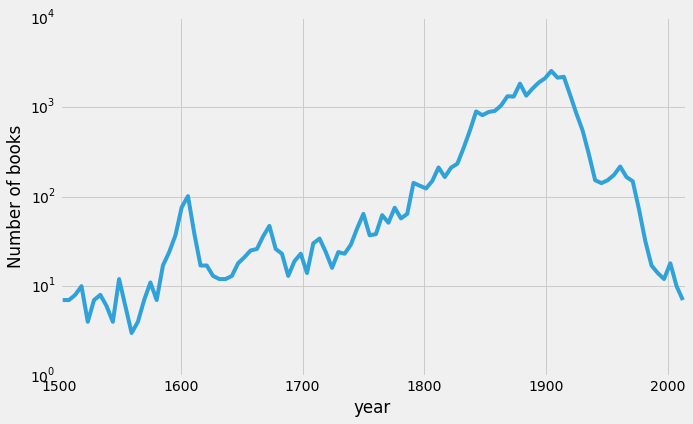

In [17]:
plt.plot(bins, vals)
plt.xlim(1500,2015)
plt.xlabel('year')
plt.ylabel('Number of books')
plt.semilogy()
pass

### Reducing network traffic by using `mapPartition`

This kind of operation is a good candidate for first computing a partial result on each partition and then following with a reduce step. 

In our `histogram` function above, the `reduceByKey` step requires a reshuffling of the data which means spending potentially a lot of time in network communication and other overhead associated with creating distributed hash tables for all the keys. 

However, since our binning function effectively already hashes the values anyway, we can avoid this by instructing first each partition to calculate its local histogram and then simply adding up the histograms in the end. In this way, we are basically combinging the `map` operation with a local `reduce` operation, and since the number of bins is always relatively small, we end up sending a trivial amount of data across the network. 

Here is where our knowledge of generators comes in handy, because the method [`mapPartitions`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.mapPartitions) *requires* a generator function. 

The key here is to define a histogram function that calculates the histogram on each partition locally. `mapPartitions` gives us an *iterator* over the data; we need to extract the data out of this iterator and calculate the local histograms *for the data in each partition*. Below, this is accomplished using the `bin_partition` function.

Finally, we define a new `histogram_partition` function that uses `bin_partition` to compute the local histograms and a simple addition in a `reduce` operation to sum up the histograms in the end. 

In [18]:
def bin_partition(iterator, nbins,  min_val, max_val) : 
    """
    Perform the binning of data contained in an iterator
    
    Arguments: 
        
        iterator: the data iterable 
        
        nbins: number of bins
        
        min_val, max_val: min and max values to consider
    
    yields the local histogram
    """
    from bisect import bisect_right
    
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    histogram = np.zeros(len(bin_edges)-1)
    
    for item in iterator : # iterating over all the items in the partition
        try : 
            ind = get_bin(bin_edges,item)
            histogram[ind] += 1
        except IndexError : 
            pass
        
    yield histogram

def histogram_partition(rdd, nbins = 100, min_val=None, max_val=None) :
    """
    Calculate a histogram of the data by using partition methods
    
    Arguments: 
    
        rdd: the data
        
    Optional Keywords:
    
        nbins: number of bins (default 100)
        
        min_val: minimum value to consider (default, min value of the input data)
        
        max_val: maximum value to consider (default, max value of the input data)
    
    Returns: 
        
        tuple of bins and array of counts
    """
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min() # FILL IN
    if max_val is None : 
        max_val = rdd.max() # FILL IN
        
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    result = (rdd.mapPartitions(lambda iterator: bin_partition(iterator, nbins, min_val, max_val))
                 .reduce(lambda a,b: a+b))
    
    return .5*(bin_edges[:-1]+bin_edges[1:]), result

In [19]:
%time bins, vals = histogram_partition(year_rdd, min_val=1500, max_val=2015)

CPU times: user 51 ms, sys: 8 ms, total: 59 ms
Wall time: 3.17 s


The difference here doesn't look dramatic because the total amount of data is rather small, but have a look at the Spark Web UI and you will see that the second implementation didn't do any shuffle writing. If you have a large number of keys, the intermediate shuffles that need to take place can have a substantial impact on performance. With a bigger data set, this difference could potentially matter quite a lot!

### Inspecting the metadata some more

Lets do a couple more checks and practice using the Spark API. 

#### How many unique authors are there in the dataset? 

1. make `author_rdd` that is composed of a string `"last_name, first_name"` (use the broadcast variable `meta_b` to get the data for each `gid`)
2. keep only the unique author strings (*hint*: look at the Spark API to find an appropriate method)
3. count the number of elements remaining

In [20]:
# TODO: map cleaned_rdd to contain the string "last_name, first_name" 
author_rdd = cleaned_rdd.map(lambda (gid, text): 
                             "%s %s"%(meta_b.value[gid]['last_name'], meta_b.value[gid]['first_name']))

In [21]:
# TODO: use RDD methods to obtain the distinct author strings and count them
n_authors = (author_rdd.distinct()
                       .count())
print("Number of distinct authors: %s " % n_authors)

Number of distinct authors: 9725 


In [22]:
#assert(n_authors == 3831)

#### Most-represented authors in the corpus: 

1. use the `author_rdd` from above
2. use the pattern `(key, 1)` to set up an RDD that can be passed to `reduceByKey`
3. run `reduceByKey`, yielding an RDD composed of `(author, count)` tuples
4. sort by descending order of number of books per author and print out the top 10 

In [23]:
# TODO: generate a list of authors, reverse-sorted by the number of books they have in the corpus
(author_rdd.map(lambda author: (author, 1))
           .reduceByKey(lambda a,b: a+b)
           .takeOrdered(10, lambda (a,c): -1*c))

[(u'Shakespeare William', 276),
 (u'Lytton Baron Lytton', 218),
 (u'Ebers Georg', 169),
 (u'Twain Mark', 156),
 (u'Parker Gilbert', 133),
 (u'Balzac Honor\xe9 de', 125),
 (u'Verne Jules', 123),
 (u'Meredith George', 110),
 (u'Jacobs W. W. (William Wymark)', 109),
 (u'Motley John Lothrop', 103)]

Finally, lets do the same thing per language, just to get an idea of how much data there is: 

In [24]:
# FILL IN 
lang_rdd = cleaned_rdd.map(lambda (gid, text): meta_b.value[gid]['lang'])

In [25]:
# FILL IN: reduce the `lang_rdd` to yield number of books in each language
lang_rdd.map(lambda l: (l,1)).reduceByKey(lambda a,b: a+b).collect()

[(u'zh', 129),
 (u'ru', 4),
 (u'bg', 5),
 (u'nah', 1),
 (u'nap', 1),
 (u'ro', 1),
 (u'ja', 21),
 (u'ga', 1),
 (u'gl', 1),
 (u'oji', 1),
 (u'kld', 1),
 (u'sr', 4),
 (u'sv', 70),
 (u'pt', 393),
 (u'sl', 1),
 (u'pl', 29),
 (u'hu', 66),
 (u'el', 120),
 (u'eo', 50),
 (u'en', 25367),
 (u'he', 3),
 (u'es', 289),
 (u'ceb', 1),
 (u'nl', 446),
 (u'no', 13),
 (u'fr', 1661),
 (u'fy', 1),
 (u'fur', 1),
 (u'myn', 1),
 (u'fi', 750),
 (u'ca', 22),
 (u'cy', 6),
 (u'cs', 8),
 (u'kha', 1),
 (u'oc', 1),
 (u'la', 35),
 (u'de', 934),
 (u'da', 36),
 (u'tl', 34),
 (u'af', 3),
 (u'te', 4),
 (u'is', 2),
 (u'it', 328),
 (u'ia', 1),
 (u'mi', 1),
 (u'enm', 2)]

## How many unique words were used in English in these 500+ years? 

We could have done the above metadata gymnastics without ever invoking a distributed processing framework by simply extracting the years from the metadata -- nevertheless we used the metadata to have a closer look at some of the RDD methods. However, the text body of each data element is where the bulk of the data volume lies. 

To construct a corpus wide vocabulary, we have to deconstruct each document into a list of words and then extract the unique words from the entire data set. If our dataset fits into memory of a single machine, this is a simple `set` operation. But what if it doesn't? 

We'll assume this is the case and instead of converting each `gid,text` pair into a `gid,list_of_words` pair, we will simply construct one global RDD of words. Here we aren't necessarily interested in preserving the provenance of words, but just finding the unique words in the whole corpus, so we drop the metadata altogether. 

The steps are as follows:

1. map the entire RDD of text into an RDD of single words (use flatMap -- this returns a different number of elements than it takes in)
2. use the `distinct` method of the resulting RDD to transform it into an RDD with only unique words

As a reminder, here's an illustration of how `flatMap` differs from `map`:

![flatMap](../figs/flatMap_example.svg)

*Hint:* In python, splitting a string into a set of words separated by spaces is easy: 

In [26]:
line = 'splitting a string is super simple'
line.split()

['splitting', 'a', 'string', 'is', 'super', 'simple']

Make an RDD `distinct_rdd` which holds the *unique English* words. Consider the steps this will require:

* use `cleaned_rdd` but keep only books in the english language (make sure you use the broadcast metadata variable!)
* convert each document into individual words
* retain only the unique words

Which RDD methods can you use to achieve these three steps? (note that this will be a pretty expensive operation so it might take some time...)

In [27]:
# TODO: create distinct_rdd by filtering for english books and using RDD methods to generate an RDD of distinct words
distinct_rdd = (cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')
                           .flatMap(lambda (gid, text): text.split())
                           .distinct())
nwords = distinct_rdd.count()
print("Number of unique English words: ", nwords)

Number of unique English words:  3439378


In [28]:
sample = distinct_rdd.takeSample(False, 1000)

In [29]:
#assert(nwords == 2807419)

**Bonus question**: can you write this by using `mapPartitions` to first make sets of words unique to each partition? It's much faster...

*hint*: use the python [set](https://docs.python.org/2/library/stdtypes.html#set) to find unique words in each partition

In [30]:
# FILL IN 
def partition_set(iterator): 
    words = set()
    
    # iterate through the data
    for text in iterator : 
        # use the "update" method of the words set to add a new set composed of all the words
        # from the "text" item. Remember that "text" is just a string, so can use the split() method
        words.update(set(text.split())) # FILL IN
    
    # now we have the unique words of the partition --> yield them into the RDD
    for word in words: 
        yield word
        

In [31]:
res = (cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')
            .values()
            .mapPartitions(partition_set)
            .distinct())
res.count()

3439378

## What are the most common words? 

A "MapReduce" tutorial has to include a word counting example -- it's basically the equivalent of a "Hello World!" example for a programming tutorial!

So, lets count the occurences of all the words across the entire corpus. This is a fairly straightforward operation, but it exposes some very common patterns that can be useful for many tasks. To simplify this a bit, we'll use only the English-language corpus for the moment.

Here are the steps we need to take:

0. keep only the english language books (use a filter)
1. `flatMap` each document into (`word, count`) pairs, but only for words that are not in the `stop_words` set
2. call `reduceByKey` to sum up all the `count`s for each word
3. finally sort it in descending order to see the most common words first

The first part here (filtering and `flatMap`) is much like what we did before, but with a twist: for each word, check that it is *not* a member of the `stop_words` set. "Stop words" include common words like "a, the, he" etc.  

*hint:* list comprehension can lead to a nice concise solution here...

In [32]:
from pickle import load
stop_words = load(open('./stop_words.dump')).union(['gutenbergtm', 'gutenberg', 'electronic', 'foundation', 'license', 'copyright', 'donation', 'donations'])

In [33]:
# TODO: create english_rdd which contains only the english books by filtering on the metadata
english_rdd = cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en').cache()

In [34]:
# TODO: use flatMap to extract the words from each document's text using the english_rdd we made above
words_rdd = (english_rdd.flatMap(lambda (gid, text): [word for word in text.split() if word not in stop_words])
                        .setName('words_rdd')
                        .cache())

Now that we have our "flattened" data set, do the counting by first mapping each word into a `(word, 1)` tuple, and then using `reduceByKey` to calculate the word frequencies. At the end of this step, use the `sortBy` method to sort the word counts in descending order. 

In [35]:
# TODO: the word count!
word_count = (words_rdd.map(lambda word: (word,1))
                       .reduceByKey(lambda a,b: a+b)
                       .sortBy(lambda (word, count): count, False)
                       .setName('word_count')
                       .cache())

In [36]:
#assert(word_count.take(5) == [('said', 1873861),('man', 1213607), ('time', 1125220), ('little', 1047679), ('like', 1025455)])

In [37]:
# fifty most common words (excluding stop words)
word_count.take(50)

[('said', 4029116),
 ('man', 2565472),
 ('time', 2470694),
 ('little', 2278162),
 ('like', 2175037),
 ('project', 2121027),
 ('did', 2037174),
 ('work', 1992250),
 ('great', 1971377),
 ('know', 1741965),
 ('old', 1656571),
 ('good', 1643871),
 ('mr', 1596189),
 ('men', 1581134),
 ('come', 1561999),
 ('way', 1501967),
 ('life', 1476909),
 ('came', 1454313),
 ('day', 1423159),
 ('long', 1400421),
 ('make', 1354099),
 ('say', 1290457),
 ('shall', 1224035),
 ('think', 1213593),
 ('new', 1198308),
 ('just', 1195726),
 ('people', 1192349),
 ('away', 1157734),
 ('thought', 1155616),
 ('went', 1135095),
 ('eyes', 1101972),
 ('right', 1084559),
 ('place', 1071763),
 ('hand', 1059031),
 ('house', 1006795),
 ('left', 1006538),
 ('years', 990291),
 ('young', 988822),
 ('face', 935343),
 ('works', 933602),
 ('things', 930710),
 ('dont', 913564),
 ('world', 886240),
 ('let', 870539),
 ('head', 863828),
 ('saw', 861317),
 ('took', 827845),
 ('god', 827134),
 ('tell', 821718),
 ('far', 814098)]

## Reduces, Shuffles, and Partitioning
During a `reduceByKey`, or any other reduction for that matter, data must be shuffled around the cluster and combined. Other common RDD methods like `join`, `sortByKey` etc. also typically require lots of data shuffling. By default, this is done in an intelligent way by first reducing values locally on each partition, and then combining the results of the partitions. Still, as is the case here, for common keys, every partition will have to send its results to others. This can result in a lot of temporary file IO if the data that needs to be communicated can't all be held in memory on all of the executors. 

One way around this is to pre-partition the data ahead of time so that the same keys land on the same partition by design. This results in much less data needing to be shipped around the network and can improve the performance. Of course, at the cost of an expensive initial shuffle that takes place during the partitioning step! But if many "by key" have to be done on the same data, it might be worth it. 

Lets have a look at these concepts by performing the word count in a few different ways. 

Now we will create a re-partitioned `words_rdd` using the default partitioning of `partitionBy` (just a hash function). You may also specify your own partitioning function. 

In [38]:
num_partitions = words_rdd.getNumPartitions()

In [39]:
par = (words_rdd.map(lambda word: (word,1))
                .partitionBy(num_partitions)
                .cache())
par.count() # call count to compute and cache the data

704361750

Since both datasets are cached in memory, we can compare the time it takes the reduce step to complete:

In [40]:
%%time
(words_rdd.map(lambda word: (word,1))
          .reduceByKey(lambda a,b: a+b)
          .count())

CPU times: user 112 ms, sys: 25 ms, total: 137 ms
Wall time: 36 s


3439052

In [41]:
%%time
par.reduceByKey(lambda a,b: a+b).count()

CPU times: user 82 ms, sys: 16 ms, total: 98 ms
Wall time: 17.1 s


3439052

Quite a speedup, but at the cost of an expensive initial shuffle. If the "by key" operation is only done once, then this is not worth it -- but if it's done repeatedly  (i.e. frequent joins) then it may be beneficial. However, we can also expect the difference to depend on the nature of the dataset. If you inspect the Spark UI, you can see that the first `reduceByKey` (i.e. one done on `word_rdd`) shuffled ~390 Mb of data, while the second `reduceByKey` (i.e. done on `par`) only shuffled ~50 Mb of data. This dataset is still pretty small, but when the shuffles are in the Gb range, the differences can be substantial. 

If you need to do lookups of individual keys, this becomes even more dramatic: 

In [42]:
%time x = words_rdd.lookup('environment')

CPU times: user 59 ms, sys: 12 ms, total: 71 ms
Wall time: 12.6 s


In [43]:
%time x = par.lookup('environment')

CPU times: user 12 ms, sys: 1 ms, total: 13 ms
Wall time: 792 ms


# Computing word frequency vs. time

Now we have all the components to build a simple tool that visualizes the relative word frequency as a function of time in the Gutenberg corpus. For inspiration, see the [Google Ngram viewer](https://books.google.com/ngrams).

### Converting documents into vectors

To make quantitative analysis of the corpus possible, we will convert each document into a vector that represents the word counts for each word appearing in the document. 

This will look something like this. Imagine we have have a corpus consisting of two "documents"

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
Then our corpus vocabulary (of 1-grams) is

    ["a", "dog", "bit", "me", "i", "the", "back"]
    
Since this is an array and each word in the array has a unique index, we can "encode" the two documents using this index mapping. Our corpus now looks like this: 

    document 1: [1, 1, 1, 1, 0, 0, 0]
    document 2: [0, 1, 1, 0, 1, 1, 1]
    
In order for the vector indices to remain consistent across the whole corpus, the first step is to build a corpus-wide lookup table, a `word --> index` mapping. 


### Generating word counts 

Once each document is converted to a vector, doing the word counts for sub-groups of documents is a simple vector addition operation. In our case, we will reduce the vectors by year, yielding an RDD that will have the total number of occurrences of each word in every year. From there, it is trivial to look up the desired word and plot the relative frequency vs. year. 

## Create the vocabulary lookup table
Create a look-up table of words by attaching a unique index to each word. The Spark API provides a [zipWithIndex](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) method that makes this easy. 

Above, we created the `word_count` RDD that already contains the unique words and their associated counts. To reduce the size of the lookup table (and the size of the vectors), we will restrict ourselves to using only the first 100k words. 

These are the steps we need to take to make the vocabulary lookup: 

1. use `zipWithIndex` on the keys of `word_count` to generate a unique index for each word -- we don't care about the counts anymore, so we can get rid of the values and just work with the keys
2. use filter to retain only the first 100000 words 
3. finally, use [collectAsMap](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) to return the resulting RDD to the driver as a dictionary. 

In [44]:
# TODO: create an RDD of (word, index) pairs and keep only the top 100000
word_lookup = (word_count.keys()
                         .zipWithIndex()
                         .filter(lambda (word, index): index < 100000)
                         .collectAsMap())

Make a `word_lookup` into a broadcast variable so we can use it on all the workers:

In [45]:
word_lookup_b = sc.broadcast(word_lookup)

This dictionary is approximately 6 Mb in size - without a broadcast, it would get sent over the network to each task, resulting in a lot of network traffic! As a broadcast variable, it gets sent only *once* to each *executor*, i.e. it's transferred only 20 times (if you are using the defaults, otherwise however many executors you have). 

## Vectorize the documents

Now that we have a vocabulary lookup table, we can use this to turn each document into a vector. 

This is done by counting up the occurrences of all words in the document that are also in the global vocabulary. 

The function `vectorize_doc` below accomplishes this by using a dictionary to keep track of the local word count. Once the counting is done we use the counts to create a sparse vector that represents the document. A sparse vector consists of two arrays, one representing the *locations* of the non-zero values, and the other the values themselves. 

To return to our contrived example from above, we had 

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
which turned into 

    document 1: [1, 1, 1, 1, 0, 0, 0]
    document 2: [0, 1, 1, 0, 1, 1, 1]

with a vocabulary of 

    ["a", "dog", "bit", "me", "i", "the", "back"]
    
As sparse vectors, these two documents could be represented with two arrays: 

    document 1: indices = [0,1,2,3]; values = [1, 1, 1, 1]
    document 2: indices = [1,2,4,5,6]; values = [1, 1, 1, 1, 1]

We use Spark's own `SparseVector` data type, for which we must specify a size, a (sorted) array of indices, and an array of values. This means that we start to save space if sparsity is > 50%. Note that the `SparseVector` provides some nice higher-level methods, but it does not allow simple operations like addition. If a lot of vector arithmetic is needed, you should use the scipy sparse types instead. 

In the next cell, we define two functions: 

* `extract_ngrams` converts a sequence of words or characters into a sequence of n-grams (here we are just using single worde, i.e. 1-grams so we'll postpone talking about ngrams until later)

* `vectorize_doc` converts a document into a sparse vector by using `extract_ngrams` to tokenize it and a vocabulary mapping to turn each word into a vector component

In [51]:
from pyspark.mllib.linalg import SparseVector

def extract_ngrams(tokens, ngram_range=[1,1], select_ngrams = None, ngram_type='word'):
    """
    Turn tokens into a sequence of n-grams 

    **Inputs**:

    *tokens*: a list of tokens

    **Optional Keywords**:

    *ngram_range*: a tuple with min, max ngram ngram_range
    
    *select_ngrams*: the vocabulary to use
    
    *ngram_type*: whether to produce word or character ngrams

    **Output**

    Generator yielding a list of ngrams in the desired range
    generated from the input list of tokens

    """
    join_str = "" if ngram_type=='character' else " "
    
    # handle token n-grams
    min_n, max_n = ngram_range
    n_tokens = len(tokens)
    
    for n in xrange(min_n, min(max_n + 1, n_tokens + 1)):
        for i in xrange(n_tokens - n + 1):
            if n == 1: 
                res = tokens[i]
            else : 
                res = join_str.join(tokens[i: i+n])
           
            # if we are using a lookup vocabulary, check for membership here
            if select_ngrams is not None : 
                if res in select_ngrams: 
                    yield res
            else : 
                yield res
            

def vectorize_doc(doc, vocab, ngram_range = [1,1], ngram_type='word') : 
    """
    Returns a vector representation of `doc` given the reference 
    vocabulary `vocab` after tokenizing it with `tokenizer`
    
    Arguments: 
        
        doc: a sequence of tokens (words or characters)
        
        vocab: the vocabulary mapping
        
    Keywords:
    
        ngram_range: the range of ngrams to process
        
        ngram_type: whether to produce character or word ngrams; default is 
        
    Returns:
    
        a sparse vector representation of the document given the vocabulary mapping
    """
    from collections import defaultdict
    from scipy.sparse import csr_matrix 
        
    # count all the word occurences 
    data = np.zeros(len(vocab))
    
    for ngram in extract_ngrams(doc, ngram_range, vocab, ngram_type) : 
         data[vocab[ngram]] += 1
            
    # only keep the nonzero indices for the sparse representation
    indices = data.nonzero()[0]
    values = data[indices]
    
    return SparseVector(len(vocab), indices, values)

Using these functions to vectorize our two-sentence test corpus: 

In [52]:
import string
s1 = "a dog bit me"
s2 = "i bit the dog back"
vocab = ["a", "dog", "bit", "me", "i", "the", "back"]
vocab_dict = {word:ind for ind, word in enumerate(vocab)}

In [53]:
print(s1)
print(vectorize_doc(s1.split(), vocab_dict))
print(s2)
print(vectorize_doc(s2.split(), vocab_dict))

a dog bit me
(7,[0,1,2,3],[1.0,1.0,1.0,1.0])
i bit the dog back
(7,[1,2,4,5,6],[1.0,1.0,1.0,1.0,1.0])


Now we have all the components we need to create an RDD of english-language books vectorized using the most common 100k words. 

1. filter the `cleaned_rdd` to keep just the english language books by using the `meta_b` broadcast variable (look up above for examples)
2. use `mapValues` to map the text of each document into a vector using the `count_doc_words` function and the `split_iter` function as the tokenizer

In [54]:
# FILL IN 
vector_rdd = english_rdd.mapValues(lambda text: vectorize_doc(text.split(), word_lookup_b.value)).cache()

In [55]:
vector_rdd.first()

(8000,
 SparseVector(100000, {0: 80.0, 1: 250.0, 2: 155.0, 3: 187.0, 4: 72.0, 5: 84.0, 6: 57.0, 7: 236.0, 8: 419.0, 9: 36.0, 10: 47.0, 11: 68.0, 12: 139.0, 13: 351.0, 14: 53.0, 15: 43.0, 16: 96.0, 17: 34.0, 18: 187.0, 19: 91.0, 20: 104.0, 21: 36.0, 22: 111.0, 23: 22.0, 24: 139.0, 25: 10.0, 26: 493.0, 27: 43.0, 28: 25.0, 29: 10.0, 30: 17.0, 31: 41.0, 32: 130.0, 33: 56.0, 34: 42.0, 35: 40.0, 36: 230.0, 37: 30.0, 38: 12.0, 39: 65.0, 40: 107.0, 41: 6.0, 42: 206.0, 43: 39.0, 44: 40.0, 45: 32.0, 46: 23.0, 47: 17.0, 48: 8.0, 49: 88.0, 50: 13.0, 51: 9.0, 52: 20.0, 53: 62.0, 54: 30.0, 55: 61.0, 56: 27.0, 57: 1.0, 58: 71.0, 59: 6.0, 60: 2.0, 61: 12.0, 62: 326.0, 63: 13.0, 64: 78.0, 65: 3.0, 66: 58.0, 67: 163.0, 68: 101.0, 69: 142.0, 70: 31.0, 71: 75.0, 72: 20.0, 73: 109.0, 74: 14.0, 75: 31.0, 76: 96.0, 77: 175.0, 78: 28.0, 79: 26.0, 80: 35.0, 81: 17.0, 82: 40.0, 83: 30.0, 84: 58.0, 85: 175.0, 86: 22.0, 87: 18.0, 88: 79.0, 89: 39.0, 90: 8.0, 92: 10.0, 93: 10.0, 94: 28.0, 95: 35.0, 96: 30.0, 97: 2

In [56]:
vector_rdd.count()

25367

## Perform the aggregation

We now have the entire Gutenberg English book corpus in the form of sparse vectors encoding the most used 100k words. 

To get the yearly sums, we will turn the metadata of each document into its publication year (i.e. the key will be the year, the value is the vector) and then do an aggregation by year. 

We will use the powerful [`treeAggregate`](http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=values#pyspark.RDD.treeAggregate) method, which requires that we specify three different components:

1. the starting aggregate
2. a function that adds a new value to the aggregate
3. a function that adds together two aggregates

The way `treeAggregate` works is that it performs the reduction in a tree pattern in order to minimize the strain on the driver. In a "normal" reduction, the workers send their results to the driver, which is tasked with putting it all together -- however, if these partial results are large (as is potentially the case here) then the driver can run into memory issues. Furthermore, most of the cluster is sitting idle while the driver performs the aggregation. `treeAggregate` fixes this by performing partial aggregations on the workers and only sending the final stages to the driver. 

The aggregation methods are powerful because the "aggregate" can be any object -- we can write a class that gets passed around to do the aggregation, for example. This allows the programmer to design a very clean interface. 

Below, we will use an instance of a dictionary as the aggregation object and define two functions that will do the actual aggregtion. 

In [57]:
def add_vector(d, data_tuple) : 
    """Add a new vector to the aggregation dictionary
    
    The vectors in the aggregation dictionary are dense since for most years we can expect that 
    this will be the case anyway. Note that we use 32-bit floats to save a bit on memory. 
    
    Arguments: 
        d: the aggregation dictionary
        
        data_tuple: the (year, vec) tuple
        
    Returns: 
        the updated aggregation dictionary 
    """
    # expand the data tuple
    year, vec = data_tuple
    
    if year in d : 
        
        d[year][vec.indices] += vec.values
    else :
        # this is the first time we've encountered this year --> make an empty vector 
        new_vec = np.zeros(vec.size, dtype=np.float32)
        
        # now put in the contents of the current vector
        new_vec[vec.indices] = vec.values
        
        # create the year in the dictionary
        d[year] = new_vec
        
    return d

def add_dicts(d1, d2) : 
    """Add two dictionaries together
    
    Arguments: 
        d1: first dictionary
        
        d2: second dictionary
        
    Returns: 
        merged dictionaries
    """
    
    # iterate through all the items in the second dictionary
    for year, vec in d2.iteritems() : 
        # if this year is also in d1, add the vectors together
        if year in d1 : 
            d1[year] += vec
        # if not, create a new year entry in d1
        else : 
            d1[year] = vec
    return d1

Now we create an RDD of `(year, vec)` pairs:

In [58]:
year_vec = vector_rdd.map(lambda (gid, vec): (publication_year(meta_b.value[gid]), vec))

Before we perform the aggregation, we can do one final bit of optimization. Passing around dictionaries full of large arrays can get expensive very quickly. The memory footprint of our partial results will depend on how heterogeneous the years on each partition or group of partitions are: if most of the data on a partition is for the same key (year in this case) then the dictionary we create on that partition will only contain a handful of vectors.  We can control this by first partitioning the RDD in a way that groups data with the same keys onto the same partitions. 

Spark provides a `partitionBy` method that does exactly this -- by default, it uses a hash function to map the keys to partitions, but you can also pass a custom partitioner if you want. If you look at the Spark UI after executing the next cell, you'll see that the partition step caused some shuffling of data, but that the aggregation itself ran very quickly and with minimal data movement. 

In [59]:
n_partitions = year_vec.getNumPartitions()

In [60]:
# TODO: use an empty dictionary and the two functions defined above as arguments to the treeAggregate method
year_sums = (year_vec.partitionBy(n_partitions)
                     .treeAggregate(dict(), add_vector, add_dicts))

Note that `year_sums` is a single "value", in this case our aggregate dictionary containing years as keys and vectors representing cummulative word counts as values. 

In [61]:
list(year_sums.iteritems())[0:10]

[(86, array([  58.,   98.,  124., ...,    0.,    0.,    0.], dtype=float32)),
 (90, array([ 19.,  30.,  57., ...,   0.,   0.,   0.], dtype=float32)),
 (93, array([ 110.,  113.,  180., ...,    0.,    0.,    0.], dtype=float32)),
 (94, array([  1.,  12.,  10., ...,   0.,   0.,   0.], dtype=float32)),
 (156, array([ 38.,  35.,  66., ...,   0.,   0.,   0.], dtype=float32)),
 (157, array([  47.,  359.,  153., ...,    0.,    0.,    0.], dtype=float32)),
 (158, array([  47.,  381.,  139., ...,    0.,    0.,    0.], dtype=float32)),
 (392, array([ 26.,  42.,  10., ...,   0.,   0.,   0.], dtype=float32)),
 (397, array([ 131.,  249.,  227., ...,    0.,    0.,    0.], dtype=float32)),
 (404, array([ 0.,  1.,  1., ...,  0.,  0.,  0.], dtype=float32))]

## Gutenberg Project N-gram viewer

Lets plot some results!

Below we define a plotting function and then make a plot of some interesting examples -- feel free to change the word list...

In [62]:
def plot_usage_frequency(words, year_data, word_lookup, plot_range = [1500,2015]) : 
    years = sorted(year_data.keys())
    tot_count = np.array([year_data[year].sum() for year in years])
    
    if type(words) is not str : 
        n_words = len(words) 
    else : 
        n_words = 1
        words = [words]
        
    for i, word in enumerate(words) : 
        word_ind = word_lookup[word]
        w_count = np.array([year_data[year][word_ind] for year in years])
        
        plt.plot(years, smooth(w_count/(tot_count-w_count)),label=word, color = plt.cm.Set1(1.*i/n_words))
    
    plt.xlim(plot_range)
    plt.xlabel('year')
    plt.ylabel('relative frequency')
    plt.legend(loc='upper left', fontsize = 'small')
    
    
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError, "smooth only accepts 1 dimension arrays."
        if x.size < window_len:
                raise ValueError, "Input vector needs to be bigger than window size."
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

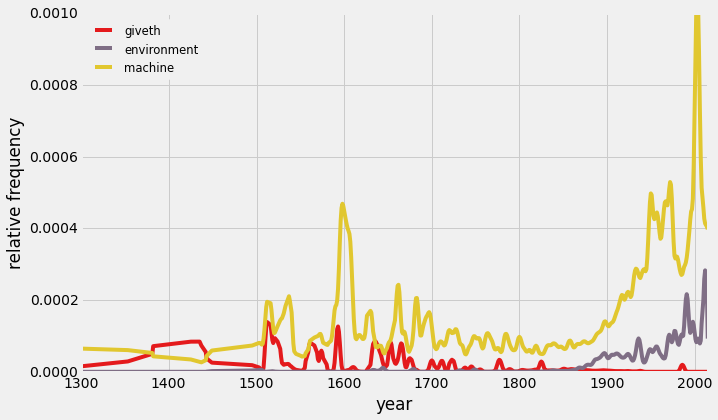

In [63]:
plot_usage_frequency(['giveth', 'environment', 'machine'], year_sums, word_lookup, [1300, 2015])
plt.ylim(0,0.001);

If you are very motivated, you can adapt the workflow above to work with higher-order n-grams and allow for the lookup of phrases (i.e. "world war") instead of just single words. To do this, you have to create a new `word_lookup` table and regenerate the vectors. Since single words (i.e. one-grams) will dominate, it might make sense to build separate list of top N-grams (top two-grams, top three-grams) and then merge them together into a vocabulary map. Beware that the size of the data will increase quickly for N > 1!

In [64]:
sc.stop()

To continue the exploration of the Gutenberg books corpus, you can move on to the [language classification notebook](part3-lang-classification-SOLUTIONS.ipynb).